## Classification

In this file we will run decision-tree models for classification.
We wish to find which features lead to a winner trades determined by the 'Outcome' which will now be dividied into 2 classifications:

     1. 'WINNER' - winning trades, with RRR>0.5
     2. 'LOSER' - losing trades, with RRR<-0.5

The purpose of the classification in not to build a model for future prediction but rather for understandable inference 
in order to take better human-made decisions in the future. Therefore a basic desicion tree for interpetation is the best choice.



In [1]:
import numpy as np
import pandas as pd
import yfinance as yf #for stock data
from IPython.display import display #for displaying the full dataframes
import matplotlib.pyplot as plt #for data visualization
import seaborn as sns #for advanced data visualization
import datetime 
import random
from sklearn import preprocessing #for ML models and data processing
import itertools  #advanced tools for loops
import math #for mathematical tools
from sklearn.preprocessing import StandardScaler



from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,  ExtraTreesClassifier, VotingClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn import tree




%matplotlib inline

 Data import and column filtering:

In [2]:
dt_in = pd.read_excel (r'data_modeling.xlsx')
dt = dt_in.drop(columns =['Unnamed: 0.1','Intended Entry','Float','SPY Week Change'
                       ,'SPY Month Change','SPY 3 Month Change','Unnamed: 0','Gap','Instrument','Outcome'
                       ,'Table Number','RRR Joint Wick and Volume Exit','is_be','RRR in-trade', 'Exit Time'
                       , 'Entry Date','Entry Time','Entry Price', 'SL Price', 'Exit Price','Highest Price'
                       , 'Potential Price', 'Volume Exit', 'Wick Exit', 'Price Behaviour', 'Negative RRR in-trade'
                       ,'Time','Missed RRR on Entry','Missed RRR','RRR Potential','RRR Difference', 'RRR Realized'
                       , 'Hard RRR Potential','RRR Volume Exit','RRR Wick Exit','VWAP Location R','VWAP','SPY Gap'])
dt

,Sector,Catalyst,Pattern,Pause Num,VWAP Tag,Daily Open,train,is_winner,is_loser,dis_entry,dis_float,norm_gap,bin_spy_gap,bin_spy_week_change,bin_spy_month_change,bin_spy_3_month_change
0,Healthcare,C,AT,1,False,5.50,1,0,1,3,2,0.559896,5,1,1,1
1,Industrial Goods,C,ST,1,False,1.84,0,0,1,2,2,0.432647,1,2,1,1
2,Services,H,ST,1,SUPPORT,9.79,1,0,1,3,5,0.885233,1,2,1,1
3,Healthcare,C,ST,2,False,6.18,1,1,0,3,3,0.325985,2,1,1,1
4,Technology,C,ST,1,BO,4.15,0,1,0,2,2,0.818447,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Healthcare,H,ST,1,False,2.04,1,0,1,2,2,0.000000,3,5,3,5
145,Services,H,AT,2,SUPPORT,5.27,1,0,0,3,1,0.192576,3,5,3,5
146,Industrial Goods,C,ST,2,False,8.61,1,0,1,4,1,1.000000,4,5,3,5
147,Healthcare,C,ST,1,False,2.80,1,0,1,2,2,0.516453,3,5,3,5


Create dummy variables from the discrete feature for feeding the model.

In [3]:
# discrete features
discrete = ["Sector",'Catalyst','Pattern','VWAP Tag']

dt1 =  pd.get_dummies(dt,columns = discrete, prefix=['sector','catalyst', 'pattern','vwap_tag'])



In [4]:
## Separate train dataset and test dataset

train = dt1[dt1['train'] ==1 ]
test = pd.concat([dt1, train, train]).drop_duplicates(keep=False)


### Dimensionality Reduction:

In this section we'll look to reduce the dimensionality of the data.
By finding the best performing features using different tree models we can decide which feature are worth keeping, after finding those worth keeping we will drop highly correlated features.

In [5]:
train = train.drop(columns = ['is_loser','train'])
test = test.drop(columns = ['is_loser','train'])

y_train = train["is_winner"]

X_train = train.drop(labels = ["is_winner"],axis = 1)

y_test = test["is_winner"]

X_test = test.drop(labels = ["is_winner"],axis = 1)


random_state = 2 #for reproduceable outcomes

In [6]:
classifiers = []
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))

clf_name = ["Ada Boost","Random Forest","Extra Trees"]

Plot the the mean feature importance of each tree based model and sum their grades which will be detemined by their index in a sorted  array of their means ( lowest is wortst, highest is best).

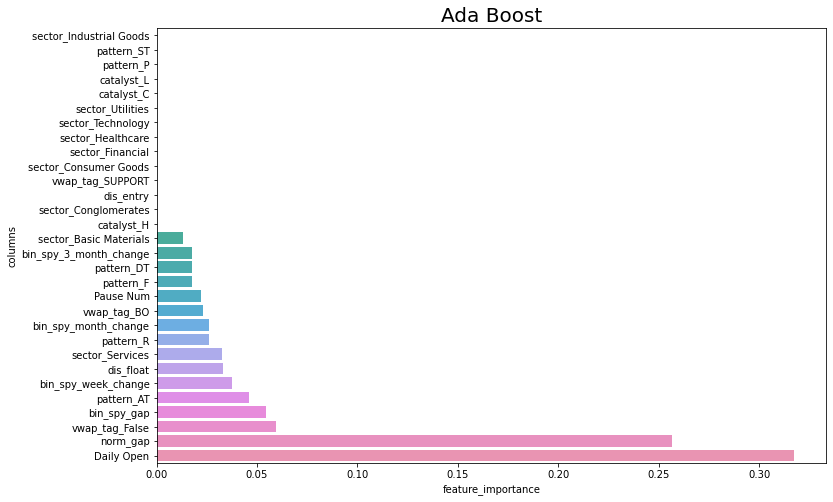

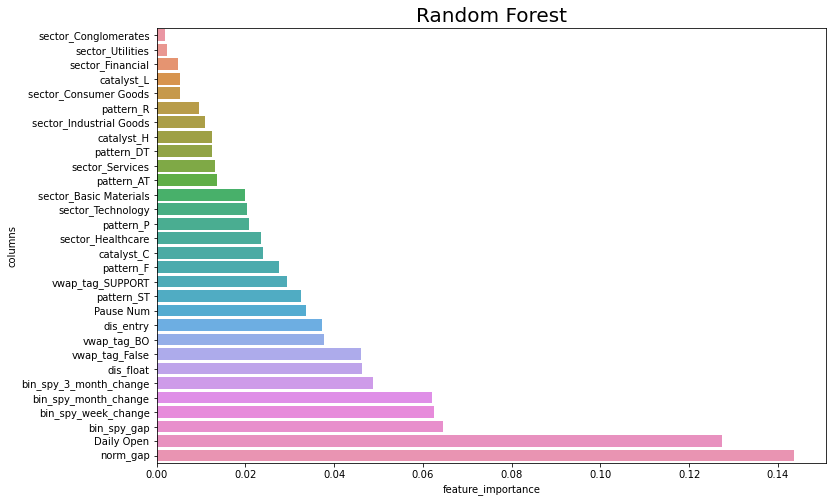

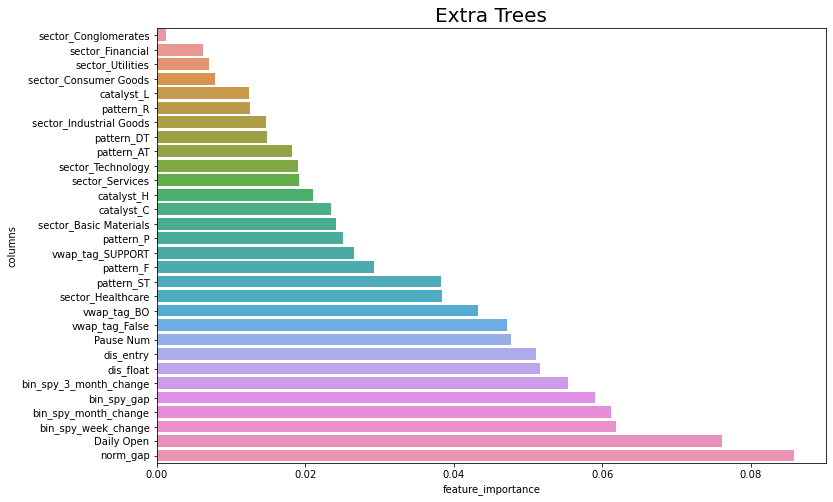

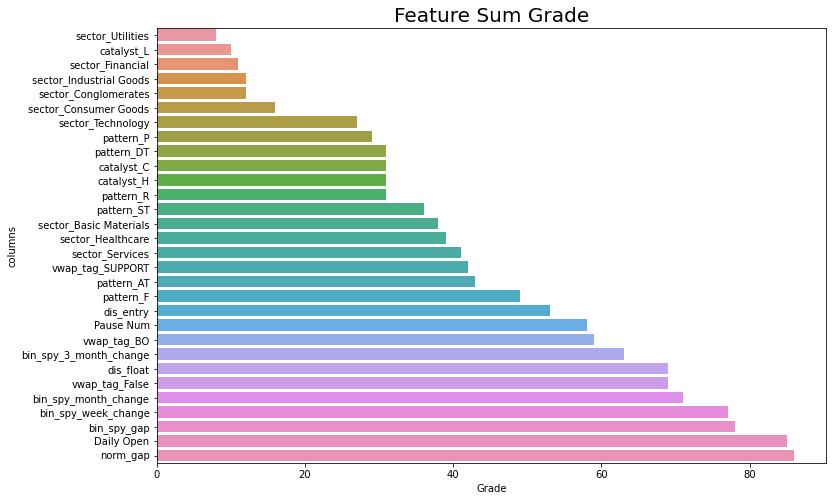

In [7]:
i=0
feature_grade = pd.DataFrame()
for clf in classifiers:
    
    importances = pd.DataFrame()
    importances['columns'] = X_train.columns
    

    model = clf.fit(X_train,y_train)
    print()
    importances['feature_importance'] = model.feature_importances_
    
    
    importances = importances.sort_values(by=['feature_importance']).reset_index(drop=True)
    
    importances['Grade'] = importances.index
    importances = importances.set_index('columns')
    
    feature_grade = feature_grade.add(importances,fill_value=0)
    
    importances = importances.reset_index()

    plt.figure(figsize=(12, 8))
    g=sns.barplot(y="columns", x="feature_importance", data=importances).set_title(clf_name[i],fontsize=20)
    i=1+i
    #g.tick_params(axis='x',labelrotation=80)

plt.figure(figsize=(12, 8))    

feature_grade = feature_grade.sort_values(by=['Grade']).reset_index()


g=sns.barplot(y="columns", x="Grade", data=feature_grade).set_title("Feature Sum Grade",fontsize=20)



Drop the weakest features, the weakest feature are the under-performing lower half as seen in the last plot.

In [8]:
weak_features = feature_grade[feature_grade["Grade"]<=50]["columns"].values

In [9]:
weak_features

array(['sector_Utilities', 'catalyst_L', 'sector_Financial',
       'sector_Industrial Goods', 'sector_Conglomerates',
       'sector_Consumer Goods', 'sector_Technology', 'pattern_P',
       'pattern_DT', 'catalyst_C', 'catalyst_H', 'pattern_R',
       'pattern_ST', 'sector_Basic Materials', 'sector_Healthcare',
       'sector_Services', 'vwap_tag_SUPPORT', 'pattern_AT', 'pattern_F'],
      dtype=object)

In [10]:
X_train=X_train.drop(columns = weak_features)
y_train=y_train.drop(columns = weak_features)

X_test=X_test.drop(columns = weak_features)
y_test=y_test.drop(columns = weak_features)

Plot the heatmap to find highly correlated feature:

* dis_entry and Daily Open are highly correlated (r >0.8), We will drop 'Daily Open' because the daily open is not a good measure of a good trade, on the other hand 'dis_entry' is a better price measure because trade decisions are made based on it.

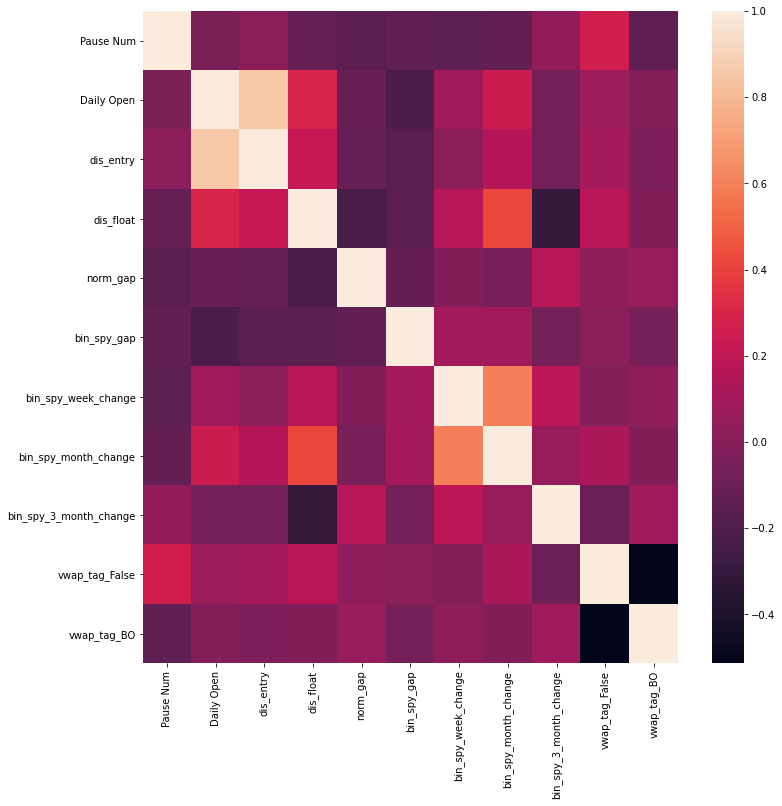

In [11]:
plt.figure(figsize=(12, 12))
ax = sns.heatmap(X_train.corr())

Drop 'Daily Open' as decided.

In [12]:
X_train=X_train.drop(columns = ["Daily Open"])
y_train=y_train.drop(columns = ["Daily Open"])

X_test=X_test.drop(columns = ["Daily Open"])
y_test=y_test.drop(columns = ["Daily Open"])

## Modeling

To choose the best decision tree we will run a grid search on different parameters, the best model will be selected using 10 - fold cross validation.

In [13]:
kfold = StratifiedKFold(n_splits=10)

clf = DecisionTreeClassifier(random_state=random_state)
param = { 'criterion':["gini","entropy"],'min_samples_split' : np.arange(5,22,2),'min_samples_leaf': np.arange(5,22)}
grid = GridSearchCV(clf,param_grid = param, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
grid = grid.fit(X_train,y_train)

grid


Fitting 10 folds for each of 306 candidates, totalling 3060 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done 3060 out of 3060 | elapsed:    6.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=2), n_jobs=4,
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_leaf': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
                         'min_samples_split': array([ 5,  7,  9, 11, 13, 15, 17, 19, 21])},
             scoring='accuracy', verbose=1)

In [14]:
DT_best = grid.best_estimator_
print( "Best estimator: " + str(DT_best))

Best estimator: DecisionTreeClassifier(min_samples_leaf=21, min_samples_split=5, random_state=2)


Model score calculated by accuracy: (true-positive + tree-negative)/ (num of observations)

In [15]:
DT_best.score(X_test,y_test)

0.6666666666666666

Model score calculated by the means of the 10-fold cross validation.

In [16]:
grid.best_score_

0.6492424242424243

Plot the tree

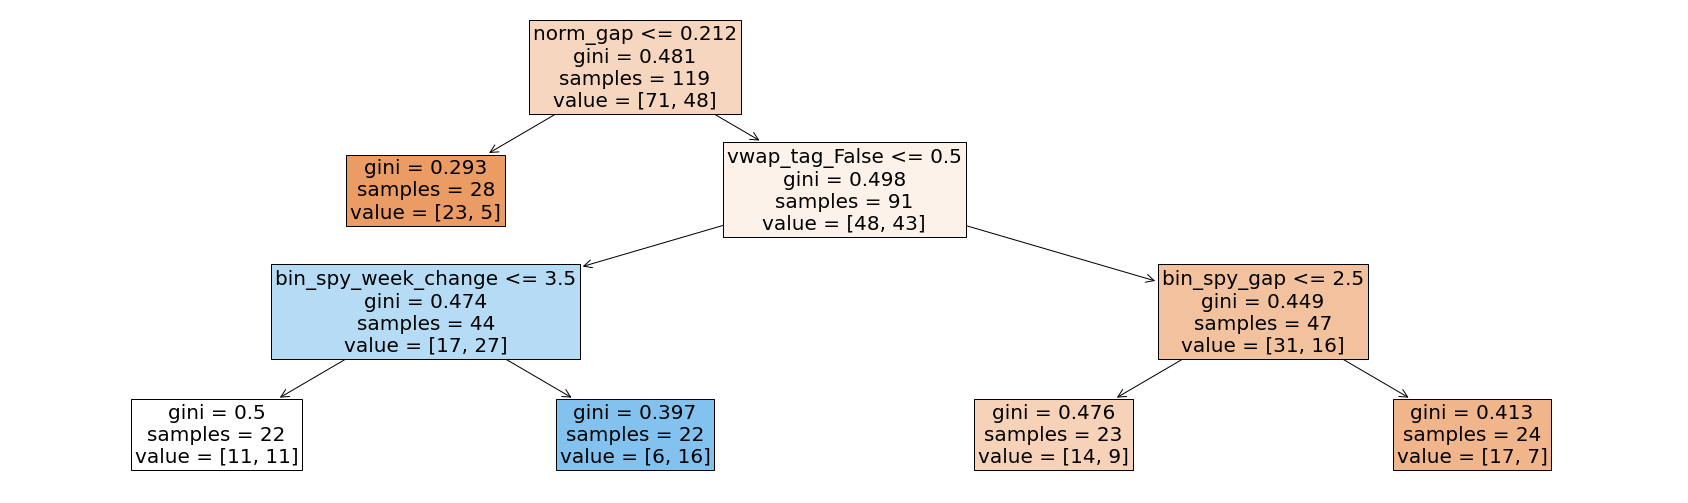

In [17]:

plt.figure(figsize=(30,9))




#plot the tree
tree.plot_tree(DT_best,filled = True,fontsize = 20,feature_names = X_train.columns) 

plt.show()

#### Revese processed values for the conclusions

In [93]:
# norm_gap node
print("Gap: " + str(dt_in[dt_in["norm_gap"]<=0.212][["Gap"]].max()))

# bin_spy_gap
print("SPY Gap :" + str(dt_in[dt_in["bin_spy_gap"]<=2.5][["SPY Gap"]].max()))

#bin_spy_week_change
print("SPY Week Change: " + str(dt_in[dt_in["bin_spy_week_change"]<=2.5][["SPY Week Change"]].max()))

Gap: Gap    1.38
dtype: float64
SPY Gap :SPY Gap   -0.003561
dtype: float64
SPY Week Change: SPY Week Change    0.17
dtype: float64


## Conclusion:

Decesion Tree:

* The 'Gap' feature has the least randomness, meaning it presents more conviction with regards to whether a trade is a winner or not, a 'norm_gap' value of 0.212 is equivalent to 1.38% gap change. In other words trade of stocks with a gap less than 1.38% tend to underperform.


* The 'VWAP TAG'  feature is second, when 'VWAP TAG' is False the trade is less preferable.


* Given 'VWAP TAG' is False if the SPY gap is at 0 we get slightly better results.


* Given 'VWAP TAG' is not False we get better results if the weekly SPY change is slightly above 0.


It is still difficult to say whether this model is accurate, unfortunately 1 of the biggest draw back is the lack of data, to have a bettet model for better decision making we'll need to continue the data collection process to see if the anomalies found in this project still hold valid.
The above takes us to the following take backs:

* Need more data
* Need more accurate data utilized by a computer, human data entries tend to be with many flaws, making the preprocessing work more challenging.

Another thing to take notice of is the SandP500 and the trade outcome relationship, it is important to collect more data for validation the relationship as seen in this project. The decision tree seen above exhibits a strong relationship between the two. This means we need to take a deeper look into this relationship to see if any clearer pattern shows up for proper exploitation.

In our next projcet we will look to collect more data, more in quantitaly and better in quality preferably using scripts.
Additionaly we'll try to build  more sophisticated models and start creating a foundation for algo-trading.





